In [53]:
#Lets get "timm", it has EfficientNet Lite 2
!pip install timm

  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
Using cached typing_extensions-4.14.1-py3-none-any.whl (43 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.5.0
    Uninstalling typing_extensions-4.5.0:
      Successfully uninstalled typing_extensions-4.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
ydata-profiling 4.16.1 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.12.0 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split
import timm
import numpy as np
import time
import matplotlib.pyplot as plt
import os

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#will convert to GPU when required

Using device: cuda


In [61]:
#Global Vars

train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1
batch_size = 32
num_of_epochs = 1

In [62]:
def make_dataset_with_subdirs(root_dir):
    classes = []
    image_paths = []
    class_to_idx = {}
    current_class_idx = 0
    
    for root, subdirs, files in os.walk(root_dir):
        if not subdirs:
            class_name = os.path.relpath(root, root_dir)
            classes.append(class_name)
            class_to_idx[class_name] = current_class_idx
            current_class_idx += 1
    
            # Get all image files in this class
            for file in files:
                if file.endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append((os.path.join(root, file), class_to_idx[class_name]))

    return image_paths, class_to_idx

data_dir = '/kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)'

In [63]:
#Plz dont rerun this shit !!

before_time = time.time()

image_paths, class_to_idx = make_dataset_with_subdirs(data_dir)
print(f"Total number of classes: {len(class_to_idx)}")
print(f"Classes: {list(class_to_idx.keys())}")

after_time = time.time()
print(f"Took around {(after_time - before_time):.2f} secs")

Total number of classes: 12
Classes: ['Water_Disaster', 'Non_Damage/Non_Damage_Wildlife_Forest', 'Non_Damage/sea', 'Non_Damage/Non_Damage_Buildings_Street', 'Non_Damage/human', 'Damaged_Infrastructure/Infrastructure', 'Damaged_Infrastructure/Earthquake', 'Human_Damage', 'Fire_Disaster/Urban_Fire', 'Fire_Disaster/Wild_Fire', 'Land_Disaster/Land_Slide', 'Land_Disaster/Drought']
Took around 1.01 secs


In [64]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor()
])

In [65]:
# Custom Dataset class that extends ImageFolder-like functionality and handles corrupted images
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, class_to_idx, transform=None):
        self.samples = image_paths
        self.class_to_idx = class_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        path, target = self.samples[index]
        
        try:
            sample = datasets.folder.default_loader(path)  # Load image
        except (OSError, IOError) as e:
            print(f"Skipping this corrupted image: {path}")
            return self.__getitem__((index + 1) % len(self.samples))  # Skip to next image if corrupted
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample, target

# Create a dataset using the custom image folder
dataset = CustomImageDataset(image_paths, class_to_idx, transform=data_transforms)

In [66]:
train_size = int(train_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [67]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=8)

In [68]:
num_classes = len(class_to_idx)

model = timm.create_model('efficientnet_lite0', pretrained=True, num_classes=num_classes)
model.to(device)

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU6(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU6(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequent

In [69]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [70]:
def train_val_with_graphs(model, train_loader, val_loader, criterion, optimizer, num_epochs=25):
    start_time = time.time()
    
    #lists
    train_losses, val_losses, train_accuracies, val_accuracies, = [], [], [], []

    for epoch in range(num_epochs):

        model.train()

        running_loss = 0.0
        running_corrects = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            #to zero out the gradients
            optimizer.zero_grad() 

            #forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            #Update the params
            optimizer.step()
            
            _, preds = torch.max(outputs, 1)

            #Scales up the loss
            running_loss += loss.item() * inputs.size(0)
            
            #preds is like 0,1,2... and laebls is also 0,1,2
            running_corrects += torch.sum(preds == labels) 

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.item())

         # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_loader.dataset)
        epoch_acc = running_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc.item())


        print('-' * 50)
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')
        print('-' * 50)
    
    # Plot training & validation loss and accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.show()

    end_time = time.time()

    print(f"Execution took: {end_time - start_time:.2f} secs")
    
    return train_losses, val_losses, train_accuracies, val_accuracies

Skipping this corrupted image: /kaggle/input/disaster-images-dataset/Comprehensive Disaster Dataset(CDD)/Damaged_Infrastructure/Infrastructure/05_01_0261.png
--------------------------------------------------
Epoch 1/1, Train Loss: 0.7081, Train Accuracy: 0.7948, Val Loss: 0.3024, Val Accuracy: 0.9015
--------------------------------------------------


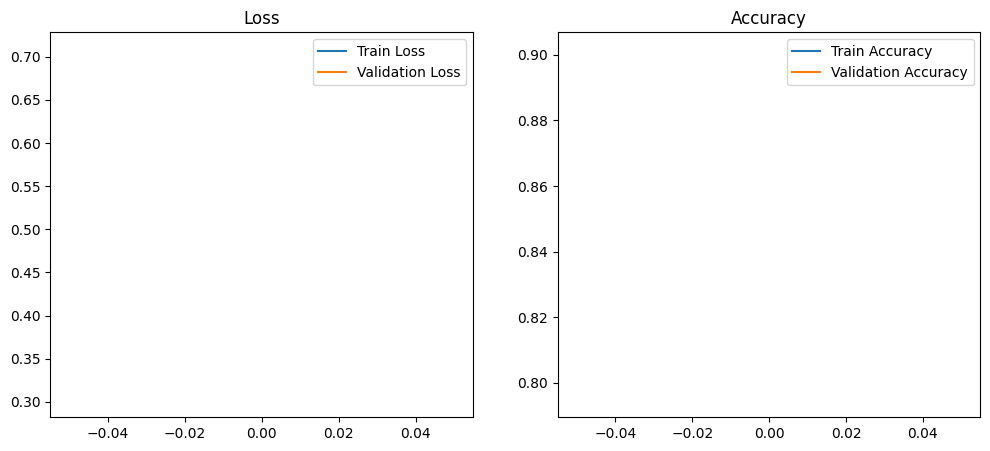

Execution took: 49.36 secs


([0.7080585301921144],
 [0.30240473117677985],
 [0.79481504900411],
 [0.9015123570638142])

In [71]:
# Train the model and visualize
train_val_with_graphs(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_of_epochs)

In [ ]:
dummy_input = torch.randn(1, 3, 224, 224, dtype=torch.float32)

# Assuming `model` is your PyTorch model and `dummy_input` is a representative input
torch.onnx.export(model, dummy_input, "model.onnx", input_names=["input"], output_names=["output"], opset_version=11)